In [85]:
## dataset
#import tensorflow.keras as keras
## for Model definition/training
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, concatenate,  Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

## required for semi-hard triplet loss:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes
import tensorflow as tf

## for visualizing 
import matplotlib.pyplot as plt, numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

import random
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from numpy.random import RandomState
from itertools import chain
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import scale

from collections import Counter
from mord import LogisticAT
import math
from matplotlib.offsetbox import AnchoredText
from os import listdir
import sys
sys.path.append('functions.py')

In [86]:
def getXData(gene_prev_filter, omic):
    x_train = pd.read_csv('data/' + omic + 'x_train.csv', index_col = 0)
    x_val = pd.read_csv('data/' + omic + 'x_val.csv', index_col = 0)
    x_test = pd.read_csv('data/' + omic + 'x_test.csv', index_col = 0)

    #filter gene data
    x_tmp = pd.concat([x_train, x_val, x_test], )
    x_tmp = x_tmp.loc[:, (x_tmp == 0).sum() < (x_tmp.shape[0] * gene_prev_filter)]
    x_train = x_tmp.loc[x_train.index.values, :]
    x_val = x_tmp.loc[x_val.index.values, :]
    x_test = x_tmp.loc[x_test.index.values, :]

    x_train = x_train + 1
    x_val = x_val + 1
    x_test = x_test + 1
    print("Number of features MTG: " + str(x_train.shape[1]))
    return(x_train, x_val, x_test)

def getYData(direct_filter, omic):
    #load data
    y_train = pd.read_csv('data/' + omic + 'y_train.csv', index_col = 0)
    y_val = pd.read_csv('data/' + omic + 'y_val.csv', index_col = 0)
    y_test = pd.read_csv('data/' + omic + 'y_test.csv', index_col = 0)
    if direct_filter == True:
        y_train = filterForProkaryotes(y_train)
        y_val = filterForProkaryotes(y_val)
        y_test = filterForProkaryotes(y_test)
    print("Number of features MBX: ", str(y_train.shape[1]))
    return(y_train, y_val, y_test)

In [87]:
%run functions.py

def getWellPredictedMetabolites(omic, prev_filter, direct_filter, layer2, metric, dim):
    x_train, x_val, x_test = getXData(prev_filter, omic)
    y_train, y_val, y_test = getYData(direct_filter, omic)
    y = y_test
    x = x_test
    y = y / np.max(np.max(y))

    weight_dir = getWeightDir(omic, metric, layer2, direct_filter, prev_filter)
    file_name = getFileName(weight_dir, dim)
    model = getModel(file_name, metric)
    preds = model.predict(x)
    preds = preds / np.max(np.max(preds))

    rs = []
    for i in np.arange(0, y.shape[1]):
        corr_res = pearsonr(preds[:, i], y.iloc[:, i])
        rs = rs  + [corr_res[0]]
    tmp = pd.DataFrame({'corr':rs, 'metabolite':y.columns.values})
    tmp = tmp.sort_values('corr', ascending = False)
    return(tmp.iloc[0:200, ].metabolite)

In [88]:
x_mbx, map_mbx = getMetabolData()
metabolites_mtg = getWellPredictedMetabolites(omic = 'mtg_metabol/', prev_filter = 0.8, direct_filter = True,
                                              layer2 = True, metric = "manhattan", dim = '25')
mbx_mtg = x_mbx.loc[:, metabolites_mtg]

metabolites_16s = getWellPredictedMetabolites(omic = '16s_metabol/', prev_filter = 0.1, direct_filter = False,
                                              layer2 = True, metric = "manhattan", dim = '25')
mbx_16s = x_mbx.loc[:, metabolites_16s]

metabolites_mtt = getWellPredictedMetabolites(omic = 'mtt_metabol/', prev_filter = 0.8, direct_filter = False,
                                              layer2 = True, metric = "euclidean", dim = '25')
mbx_mtt = x_mbx.loc[:, metabolites_mtt]

all_omics_metabolites = np.unique([metabolites_16s, metabolites_mtg, metabolites_mtt])
print(len(all_omics_metabolites))
all_omics = x_mbx.loc[:, all_omics_metabolites]
train_bool, test_bool = splitDatasets(x_mbx, map_mbx, return_bool= True, state = 1)

Number of features MTG: 5680
Number of features MBX:  291
weights/mtg_metabol//direct_filter/prev_filt0.8/layer2/manhattan/
Number of features MTG: 18
Number of features MBX:  1267
weights/16s_metabol//no_filter/prev_filt0.1/layer2/manhattan/
Number of features MTG: 5553
Number of features MBX:  1267
weights/mtt_metabol//no_filter/prev_filt0.8/layer2/euclidean/
504


In [89]:
def dropLowStd(data):
    return(data.loc[:, np.std(data, axis = 0) > 0])

def normalize(data):
    return((data - np.mean(data, axis = 0)) / (np.var(data, axis = 0)))

def logTransform(data):
    return(np.log(data + 1))

In [90]:
%run ml_functions.py
%run functions.py

data_storage = Storage([x_mbx, x_mbx, x_mbx, x_mbx, x_mbx])
encoded_storage = Storage([mbx_16s, mbx_mtg, mbx_mtt, x_mbx, all_omics])
mapping_storage = Storage([map_mbx, map_mbx, map_mbx, map_mbx, map_mbx])
data_storage.applyFunction(dropLowStd)
encoded_storage.applyFunction(dropLowStd)
data_storage.applyFunction(scale)
encoded_storage.applyFunction(scale)


In [91]:
tmp = pd.DataFrame()

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


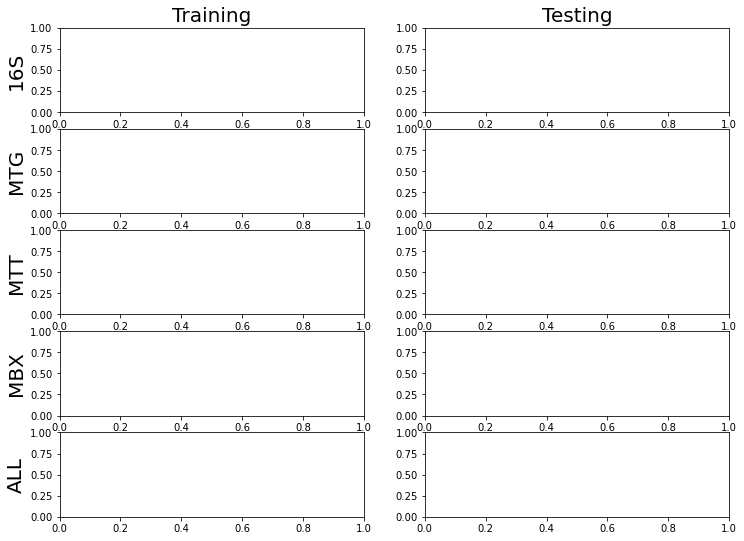

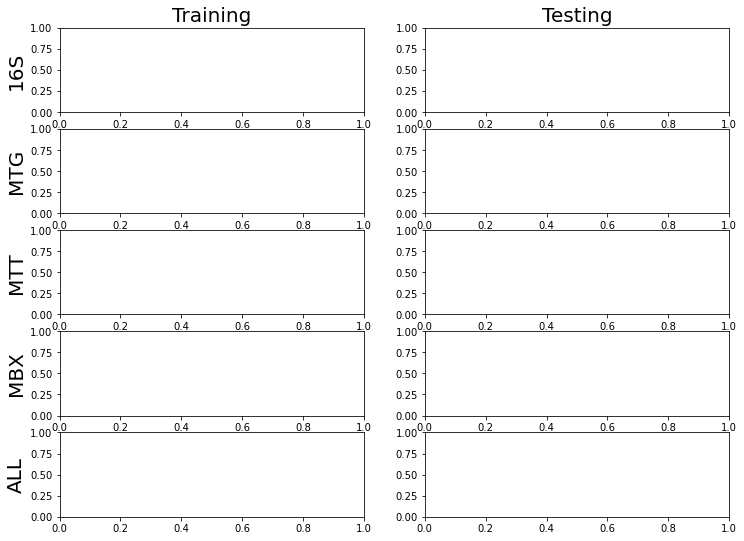

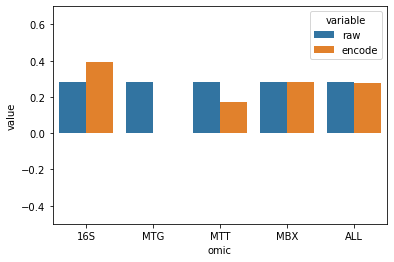

In [92]:
criteria = "fruit"
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              criteria, 'rf', transformOrdinal_fruit)
tmp[criteria] = res_raw +  res_encode
tmp.index = ['raw_16S', 'raw_MTG', 'raw_MTT', 'raw_MBX', 'raw_ALL',
                    'autoencode_16S', 'autoencode_MTG', 'autoencode_MTT', 'autoencode_MBX', 'autoencode_ALL']

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


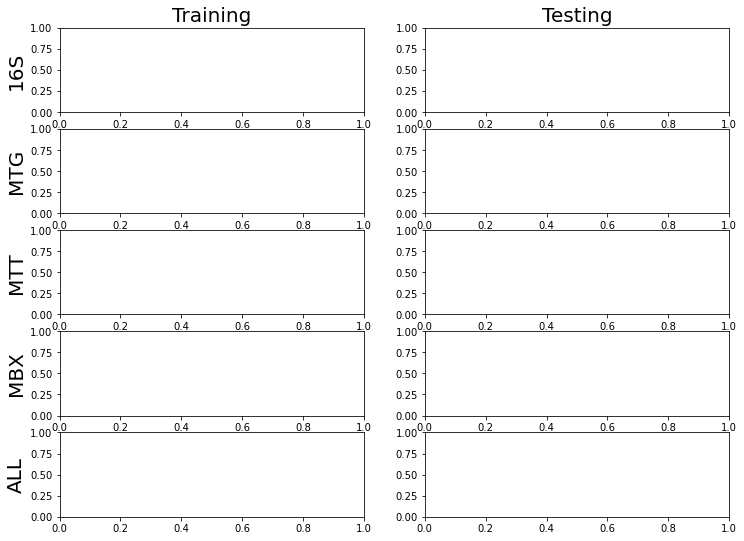

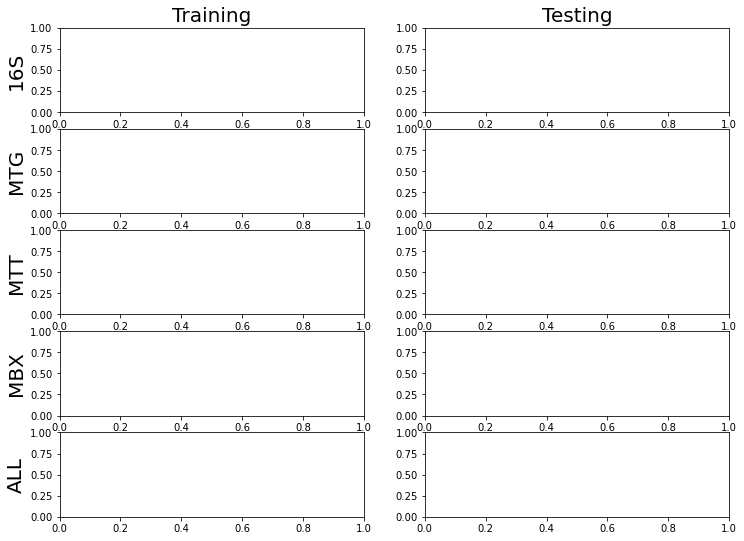

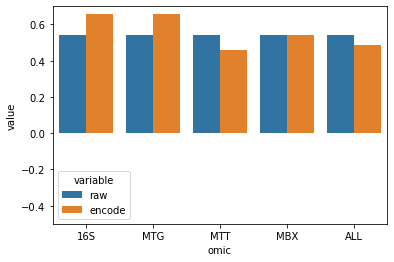

In [93]:
criteria = "dairy"
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              criteria, 'rf', transformOrdinal_fruit)
tmp[criteria] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


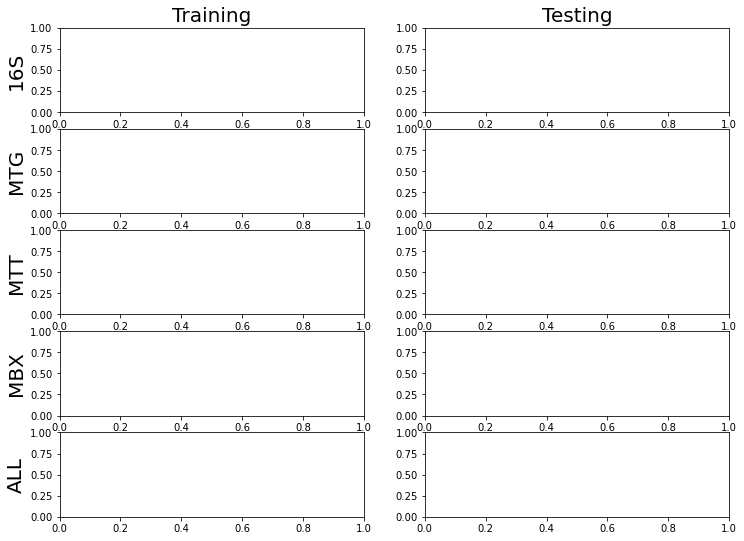

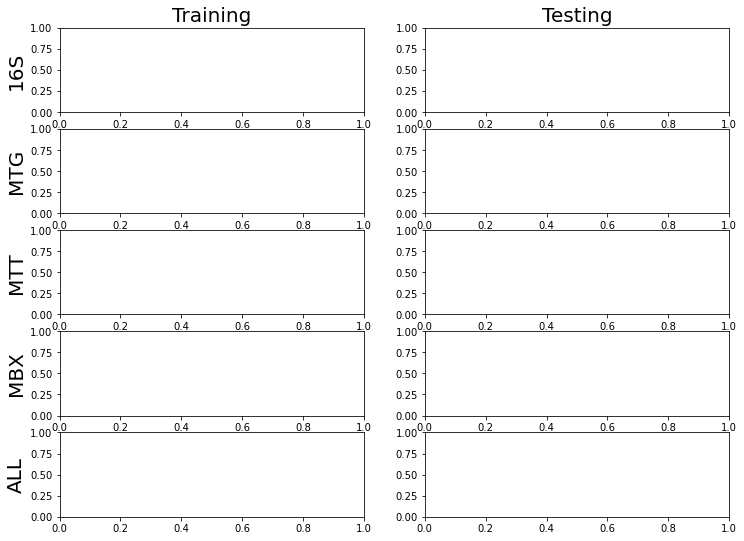

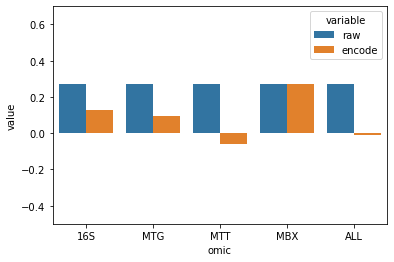

In [94]:
criteria = "multivitamin"
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              criteria, 'rf', transformOrdinal_fruit)
tmp[criteria] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


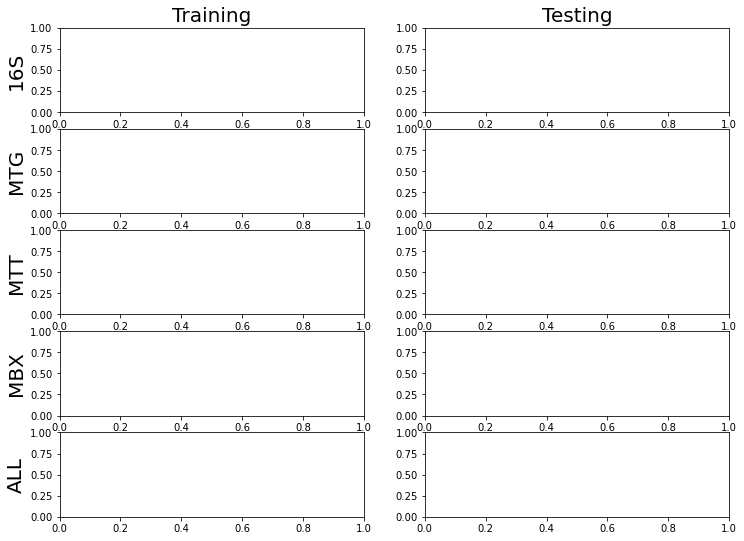

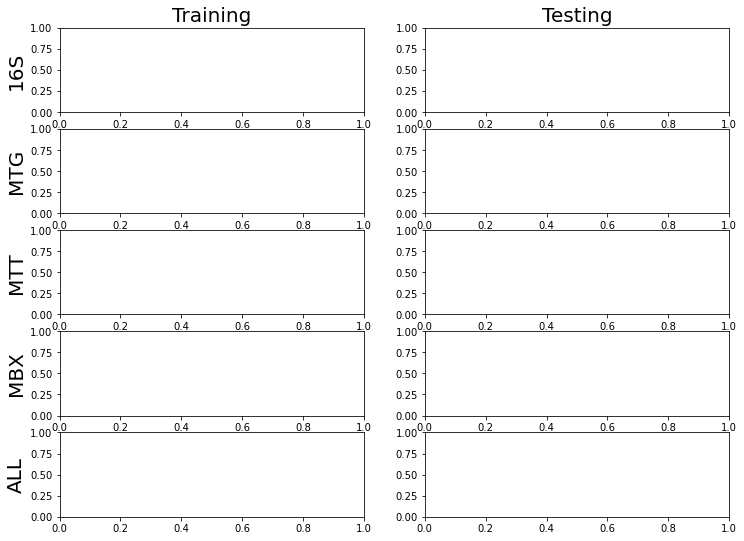

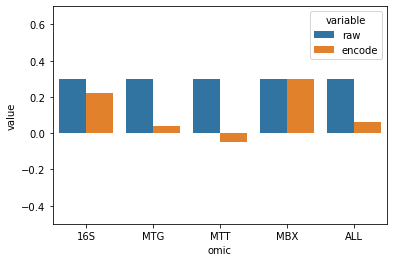

In [95]:
criteria = "vegetable"
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              criteria, 'rf', transformOrdinal_fruit)
tmp[criteria] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


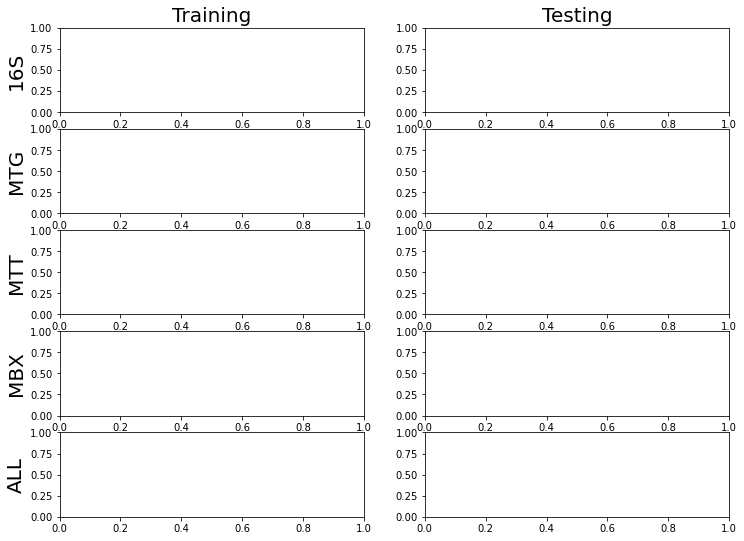

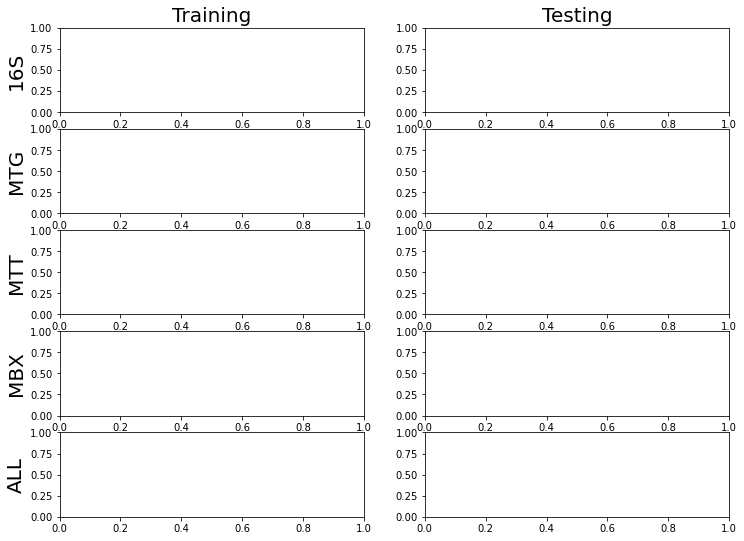

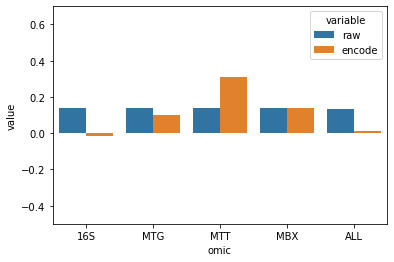

In [96]:
criteria = "olive_oil"
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              criteria, 'rf', transformOrdinal_fruit)
tmp[criteria] = res_raw +  res_encode

('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL
('16S', 'MTG', 'MTT', 'MBX', 'ALL')
0
RAW 16S
1
RAW MTG
2
RAW MTT
3
RAW MBX
4
RAW ALL


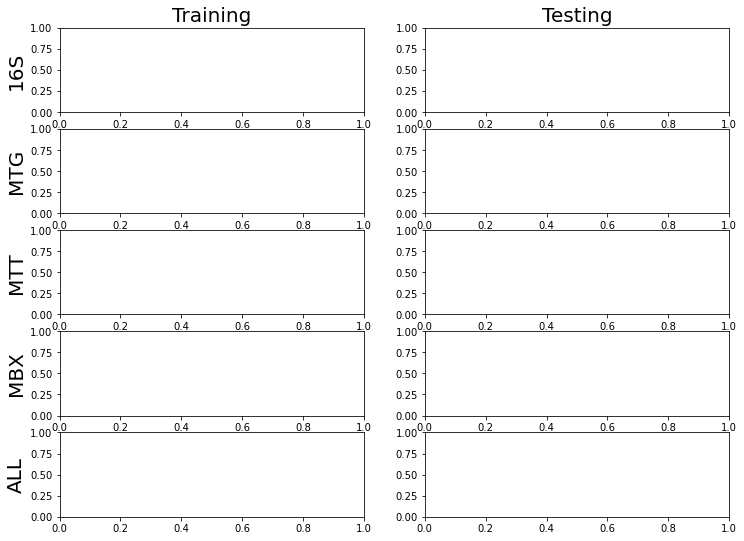

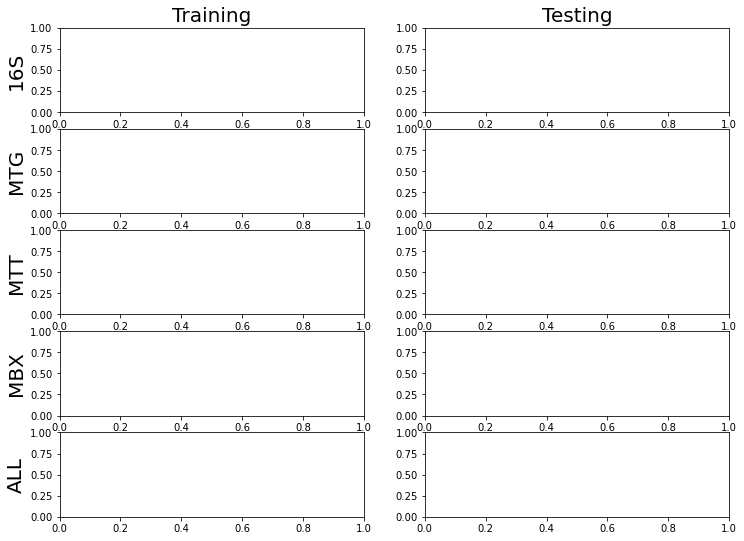

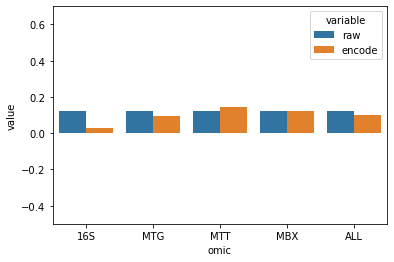

In [97]:
for i in np.arange(len(mapping_storage.getList())):
    mapping_storage.getList()[i].phenotype = [True if i == 'A' else False for i in mapping_storage.getList()[i].phenotype]
res_raw, res_encode = runCompareOmicsPipeline(data_storage, encoded_storage, mapping_storage, train_bool, test_bool,
                                              'phenotype', 'rf', transform = None)
tmp['phenotype'] = res_raw +  res_encode

In [98]:
all_omics.shape
x_mbx.shape

(175, 1267)